## Minimal notebook

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import requests

import seaborn as sns

from collections import Counter
import itertools

from matplotlib.colors import LogNorm, SymLogNorm, Normalize
from matplotlib.ticker import MaxNLocator, FormatStrFormatter

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/manuelmorales/miniconda3/envs/training/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Import database

In [2]:
# always use False
LOCAL = False

if LOCAL:
    f = open('data/inspire_LA.json','r')
    df = json.load(f)
    f.close()
else:
    r = requests.get('https://github.com/restrepo/inspireauth/raw/main/data/inspire_LA.json')
    df = r.json()

db_master = pd.DataFrame(df)
db_master.head()

,author_id,country,email_addresses,full_name,ids,institution,institution_id,name,papers,positions,profile_id,advisors
0,H.Albrecht.1,Venezuela,"[{'value': 'hartwig.albrecht@desy.de', 'curren...","Albrecht, Hermann","[{'value': 'H.Albrecht.1', 'schema': 'INSPIRE ...","Unlisted, VE",912061,"{'value': 'Albrecht, Hartwig', 'preferred_name...","[{'recid': 2023395, 'year': '2021', 'citation_...",[{'record': {'$ref': 'https://inspirehep.net/a...,1018731,[]
1,D.M.B.R.1,Venezuela,None,"Bellorin, David","[{'value': 'D.M.B.R.1', 'schema': 'INSPIRE BAI'}]","Unlisted, VE",912061,"{'value': 'R., David M. Bellorin'}","[{'recid': 2023395, 'year': '2021', 'citation_...",None,2023397,[]
2,D.F.Mundarain.1,Chile,None,"Mundarain, Douglas F.","[{'value': 'D.F.Mundarain.1', 'schema': 'INSPI...",Catolica del Norte U.,908143,"{'value': 'Mundarain, Douglas F.'}","[{'recid': 2023395, 'year': '2021', 'citation_...",None,2023398,[]
3,R.Gaitan.2,Venezuela,"[{'value': 'rgaitan@uc.edu.ve', 'current': Fal...","Dominguez, Yessica","[{'value': 'R.Gaitan.2', 'schema': 'INSPIRE BA...","Unlisted, VE",912061,"{'value': 'Gaitan, Rolando', 'preferred_name':...","[{'recid': 1863076, 'year': '2021', 'citation_...","[{'rank': 'PHD', 'record': {'$ref': 'https://i...",1864347,[]
4,J.Ntahompagaze.1,Rwanda,None,"Ntahompagaze, Joseph","[{'value': 'J.Ntahompagaze.1', 'schema': 'INSP...","EAIFR, Kigali",1636656,"{'value': 'Ntahompagaze, Joseph'}","[{'recid': 2087212, 'year': '2022', 'citation_...",None,2087213,[]


# All countries in the database

In [3]:
# find all countries in json
all_countries = db_master['country'].unique()
# get rid of Nonetypes in the database
all_countries = [country for country in all_countries if country is not None]
# sort countries 
all_countries.sort()

print(len(all_countries))

for country in all_countries:
    print(country)
    
# format country 
def format_country(country):
    country = country.lower()
    ans = country.replace(" ", "_")
    return ans

115
Algeria
Argentina
Armenia
Australia
Austria
Azerbaijan
Bahamas
Bangladesh
Belarus
Belgium
Benin
Bhutan
Bolivia
Bosnia and Herzegovina
Brazil
Brunei Darussalam
Bulgaria
Canada
Chile
China
Colombia
Congo
Costa Rica
Croatia
Cuba
Cyprus
Czechia
Denmark
Dominican Republic
Ecuador
Egypt
El Salvador
Estonia
Ethiopia
Finland
France
Georgia
Germany
Ghana
Greece
Guatemala
Holy See (Vatican City State)
Honduras
Hungary
Iceland
India
Indonesia
Iran, Islamic Republic of
Iraq
Ireland
Israel
Italy
Jamaica
Japan
Jordan
Kazakhstan
Korea, Republic of
Kuwait
Kyrgyzstan
Latvia
Lebanon
Lithuania
Luxembourg
Madagascar
Malaysia
Malta
Mexico
Moldova
Mongolia
Montenegro
Morocco
Netherlands
New Zealand
Niger
Nigeria
North Macedonia
Norway
Oman
Pakistan
Palestine, State of
Panama
Paraguay
Peru
Philippines
Poland
Portugal
Puerto Rico
Qatar
Romania
Russian Federation
Rwanda
Saudi Arabia
Serbia and Montenegro
Singapore
Slovakia
Slovenia
South Africa
Spain
Sri Lanka
Sweden
Switzerland
Syrian Arab Republic
Taiwan

# Latin American countries 

In [4]:
# 19 Latin American countries indexed in the database
LA_countries = [
    'Argentina',
    'Bolivia',
    'Brazil',
    'Chile',
    'Colombia',
    'Costa Rica',
    'Cuba',
    'Dominican Republic', # new
    'Ecuador',
    'El Salvador', # new
    'Guatemala',
    'Honduras',
    'Mexico',
    'Panama', # new
    'Paraguay',
    'Peru',
    'Puerto Rico', # new
    'Uruguay',
    'Venezuela'
]

# Jamaica, Bahamas not included. 

LA_countries_format = [format_country(country) for country in LA_countries]

# See what authors are duplicated for a given country

In [5]:
db = db_master[db_master['country'] == 'Chile']
duplicated_indices = db[db['author_id'].duplicated()].index
# select the first two rows that contain a duplicated entry
result = db.loc[duplicated_indices[:2]]
print(result)

       author_id country email_addresses       full_name   ids  \
504   N.Calvet.1   Chile            None   Calvet, Nuria  None   
506  C.Briceno.1   Chile            None  Briceno, Cesar  None   

            institution institution_id  name  \
504  Chile U., Catolica         904336  None   
506  Chile U., Catolica         904336  None   

                                                papers positions profile_id  \
504  [{'recid': 662521, 'year': '2005', 'citation_c...      None       None   
506  [{'recid': 662521, 'year': '2005', 'citation_c...      None       None   

    advisors  
504       []  
506       []  


# Total and active authors per year

In [6]:
# Get number of authors 

def get_number_authors(country):
    # select country
    db=db_master[db_master['country']==country].reset_index(drop=True)
    # remove duplicate authors according to `author_id`
    # if, after a selecting a country, there are rows with
    # the same author_id, it's because the author published
    # under two affilitaions of the same country. Obviously,
    # this only counts as one author of the country. 
    # We don't drop duplicates by suing `profile_id` because
    # it is full of Nonetypes 
    db = db.drop_duplicates(subset=['author_id'])
    number_of_authors = len(db.index)
    print(f"{country}: {number_of_authors} authors.")
    return number_of_authors


In [7]:
db_test = db_master[db_master['country']=='Dominican Republic'].reset_index(drop=True) 

In [8]:
db_test.head()

,author_id,country,email_addresses,full_name,ids,institution,institution_id,name,papers,positions,profile_id,advisors
0,Daniel.Sudarsky.1,Dominican Republic,"[{'value': 'sudarsky@nucleares.unam.mx', 'curr...","Sudarsky, Daniel","[{'value': 'I4AlvWAAAAAJ', 'schema': 'GOOGLESC...","Santo Domingo, PUCMM",906531,"{'value': 'Sudarsky, Daniel', 'name_variants':...","[{'recid': 35032, 'year': '1993', 'citation_co...","[{'rank': 'SENIOR', 'record': {'$ref': 'https:...",987260,"[{'ids': [{'value': 'INSPIRE-00081421', 'schem..."
1,Daniel.Sudarsky.1,Dominican Republic,"[{'value': 'sudarsky@nucleares.unam.mx', 'curr...","Sudarsky, D.","[{'value': 'I4AlvWAAAAAJ', 'schema': 'GOOGLESC...","Santo Domingo, Autonoma U.",907039,"{'value': 'Sudarsky, Daniel', 'name_variants':...","[{'recid': 35032, 'year': '1993', 'citation_co...","[{'rank': 'SENIOR', 'record': {'$ref': 'https:...",987260,"[{'ids': [{'value': 'INSPIRE-00081421', 'schem..."


In [9]:
def generate_number_authors_all():
    ans = {}
    for country in LA_countries:
        ans[country] = get_number_authors(country)
    return ans

authors = generate_number_authors_all();

Argentina: 1984 authors.
Bolivia: 50 authors.
Brazil: 8456 authors.
Chile: 2043 authors.
Colombia: 723 authors.
Costa Rica: 29 authors.
Cuba: 236 authors.
Dominican Republic: 1 authors.
Ecuador: 66 authors.
El Salvador: 6 authors.
Guatemala: 32 authors.
Honduras: 11 authors.
Mexico: 3867 authors.
Panama: 3 authors.
Paraguay: 5 authors.
Peru: 156 authors.
Puerto Rico: 10 authors.
Uruguay: 87 authors.
Venezuela: 370 authors.


# Generate the histogram

In [10]:
# Population of each country

"""
Arrays account for 
- Argentina
- Bolivia
- Brazil
- Chile
- Colombia
- Costa Rica
- Cuba
- Dominican Republic
- Ecuador
- El Salvador
- Guatemala
- Honduras
- Mexico
- Panama
- Paraguay
- Peru
- Puerto Rico
- Uruguay
- Venezuela
"""

#populations = [45.606, 11.833, 213.993, 19.212, 51.266,
#               5.139, 11.318, 17.888, 18.250, 10.063,
#               130.262, 7.220, 33.359, 3.485, 28.705]

# population in millions of inhabitants
population = {element: None for element in LA_countries}

population['Argentina'] = 45.606
population['Bolivia'] = 11.833
population['Brazil'] = 213.993
population['Chile'] = 19.212
population['Colombia'] = 51.266
population['Costa Rica'] = 5.139
population['Cuba'] = 11.318
population['Dominican Republic'] = 10.954
population['Ecuador'] = 17.888
population['El Salvador'] = 6.158
population['Guatemala'] = 18.250
population['Honduras'] = 10.063
population['Mexico'] = 130.262
population['Panama'] = 4.382
population['Paraguay'] = 7.220
population['Peru'] = 33.359
population['Puerto Rico'] = 2.828
population['Uruguay'] = 3.485
population['Venezuela'] = 28.705

In [11]:
authors_pc = {k: authors[k] / population[k] for k in authors}

# Generate active authors

In [12]:
def drop_recid_duplicates(papers: list):
    """
    In a list of dictionaries, remove all the duplicates
    that have the same 'recid' key
    """
    unique_dicts = {}
    
    for paper in papers:
        key_value = paper.get('recid')
        if key_value not in unique_dicts:
            unique_dicts[key_value] = paper
    
    filtered_list = list(unique_dicts.values())
    
    return filtered_list
    

In [13]:
def remove_duplicate_dicts(input_list, key='recid'):
    seen = set()
    output_list = []
    
    for item in input_list:
        if item[key] not in seen:
            seen.add(item[key])
            output_list.append(item)
    
    return output_list


In [14]:
def filter_papers(papers, inst_list):
    filtered_papers = [paper for paper in papers if paper.get('instituion_id') in inst_list]    
    return filtered_papers

In [15]:
def active_author(papers, curr_year=2022):
    """
    Determines if an author is active or not
    Parameters
    ----------
        papers : list
    Returns
    -------
        bool
    """
    years = []
    if papers is not None:
        for paper in papers:
            # get the year of the paper if the string
            # can be mapped to a digit
            if paper.get('year').isdigit():
                years.append(paper.get('year'))
        years = list(map(int, years))
    if len(years) >= 1:
        max_year = max(years)
        return (curr_year - max_year) <= 5
    else:
        return False
    
# db.iloc[456].papers is a patological example.
# The function above should take care of it. 

# Small test 

In [16]:
db_test.head()

,author_id,country,email_addresses,full_name,ids,institution,institution_id,name,papers,positions,profile_id,advisors
0,Daniel.Sudarsky.1,Dominican Republic,"[{'value': 'sudarsky@nucleares.unam.mx', 'curr...","Sudarsky, Daniel","[{'value': 'I4AlvWAAAAAJ', 'schema': 'GOOGLESC...","Santo Domingo, PUCMM",906531,"{'value': 'Sudarsky, Daniel', 'name_variants':...","[{'recid': 35032, 'year': '1993', 'citation_co...","[{'rank': 'SENIOR', 'record': {'$ref': 'https:...",987260,"[{'ids': [{'value': 'INSPIRE-00081421', 'schem..."
1,Daniel.Sudarsky.1,Dominican Republic,"[{'value': 'sudarsky@nucleares.unam.mx', 'curr...","Sudarsky, D.","[{'value': 'I4AlvWAAAAAJ', 'schema': 'GOOGLESC...","Santo Domingo, Autonoma U.",907039,"{'value': 'Sudarsky, Daniel', 'name_variants':...","[{'recid': 35032, 'year': '1993', 'citation_co...","[{'rank': 'SENIOR', 'record': {'$ref': 'https:...",987260,"[{'ids': [{'value': 'INSPIRE-00081421', 'schem..."


In [17]:
inst_test = db_test['institution_id'].drop_duplicates().to_list()
print(inst_test)

['906531', '907039']


In [18]:
papers_test = db_test.iloc[0].papers

In [19]:
papers_repeated = [paper for paper in papers_test if paper['recid'] == 401209]
papers_repeated

[{'recid': 401209,
  'year': '1995',
  'citation_count': 133,
  'primary_arxiv_category': [],
  'journal_id': '1214779',
  'author_id': 'Daniel.Sudarsky.1',
  'instituion_id': '903003'},
 {'recid': 401209,
  'year': '1995',
  'citation_count': 133,
  'primary_arxiv_category': [],
  'journal_id': '1214779',
  'author_id': 'Daniel.Sudarsky.1',
  'instituion_id': '907039'}]

In [20]:
filtered_papers = [paper for paper in papers_test if paper.get('instituion_id') in inst_test]

In [21]:
filtered_papers

[{'recid': 35032,
  'year': '1993',
  'citation_count': 51,
  'primary_arxiv_category': ['gr-qc'],
  'journal_id': 'None',
  'author_id': 'Daniel.Sudarsky.1',
  'instituion_id': '906531'},
 {'recid': 373019,
  'year': '1994',
  'citation_count': 0,
  'primary_arxiv_category': [],
  'journal_id': 'None',
  'author_id': 'Daniel.Sudarsky.1',
  'instituion_id': '906531'},
 {'recid': 366784,
  'year': '1993',
  'citation_count': 0,
  'primary_arxiv_category': [],
  'journal_id': 'None',
  'author_id': 'Daniel.Sudarsky.1',
  'instituion_id': '907039'},
 {'recid': 369157,
  'year': 'None',
  'citation_count': 0,
  'primary_arxiv_category': [],
  'journal_id': 'None',
  'author_id': 'Daniel.Sudarsky.1',
  'instituion_id': '907039'},
 {'recid': 401209,
  'year': '1995',
  'citation_count': 133,
  'primary_arxiv_category': [],
  'journal_id': '1214779',
  'author_id': 'Daniel.Sudarsky.1',
  'instituion_id': '907039'}]

# Continue with the analysis

In [22]:
def get_active_authors(country):
    # select country
    db=db_master[db_master['country']==country].reset_index(drop=True)
    
    # obtain the list of institution of the country
    institution_list = db['institution_id'].drop_duplicates().to_list()
    
    # drop recid duplicates
    #db['papers_unique_recid'] = db['papers'].apply(drop_recid_duplicates)
    #db['papers_unique_recid'] = db['papers'].apply(lambda x: remove_duplicate_dicts(x))
    
    # create column of filtered papers
    #db['papers_filtered'] = db['papers_unique_recid'].apply(lambda x: filter_papers(x, institution_list))
    db['papers_filtered'] = db['papers'].apply(lambda x: filter_papers(x, institution_list))
    
    # just now we drop the duplicates according to author_id. 
    # we needed them before to obtain the list of institution of the country
    db = db.drop_duplicates(subset=['author_id'])
    
    # This has finished the main part of the routine.
    n_authors = db['papers_filtered'].apply(lambda x: active_author(x)).sum()
    print(f"{country}: {n_authors} authors.")
    
    return n_authors
    

In [23]:
# DEPRECATED
# Get number of active authors 

#def get_active_authors(country):
#    # select country
#    db=db_master[db_master['country']==country].reset_index(drop=True)
#    # remove duplicate authors according to `author_id`
#    # if, after a selecting a country, there are rows with
#    # the same author_id, it's because the author published
#    # under two affilitaions of the same country. Obviously,
#    # this only counts as one author of the country. 
#    # We don't drop duplicates by suing `profile_id` because
#    # it is full of Nonetypes 
#    db = db.drop_duplicates(subset=['author_id'])
#    n_authors = db.papers.apply(lambda x: active_author(x)).sum()
#    print(f"{country}: {n_authors} authors.")
#    return n_authors

In [24]:
def generate_active_authors_all():
    ans = {}
    for country in LA_countries:
        ans[country] = get_active_authors(country)
    return ans

act_authors = generate_active_authors_all()

Argentina: 730 authors.
Bolivia: 12 authors.
Brazil: 3659 authors.
Chile: 811 authors.
Colombia: 406 authors.
Costa Rica: 10 authors.
Cuba: 85 authors.
Dominican Republic: 0 authors.
Ecuador: 54 authors.
El Salvador: 1 authors.
Guatemala: 28 authors.
Honduras: 7 authors.
Mexico: 1749 authors.
Panama: 2 authors.
Paraguay: 3 authors.
Peru: 68 authors.
Puerto Rico: 9 authors.
Uruguay: 47 authors.
Venezuela: 58 authors.


In [25]:
act_authors_pc = {k: act_authors[k] / population[k] for k in authors}

# Generate histogram

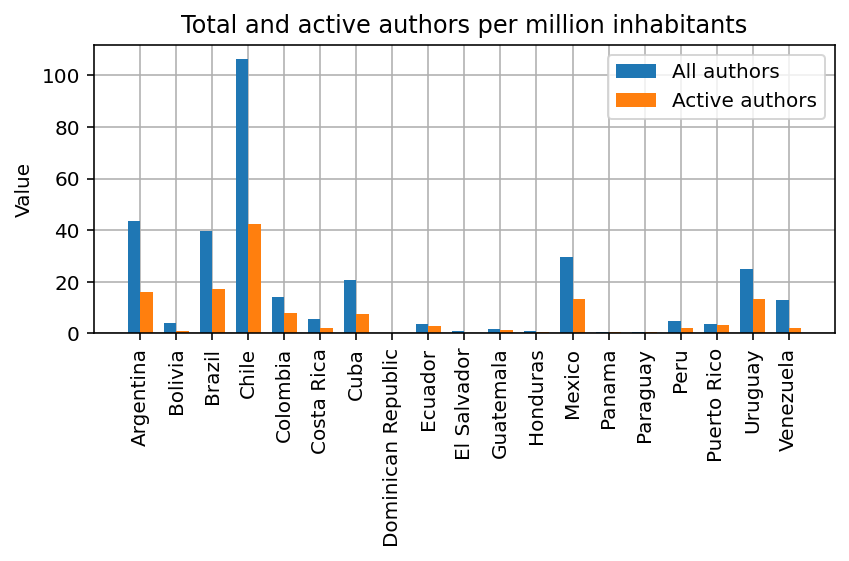

In [26]:
def gen_all_auths_pc():
    labels = LA_countries
    all_auths = authors_pc.values()
    act_auths = act_authors_pc.values()

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, all_auths, width, label='All authors')
    rects2 = ax.bar(x + width/2, act_auths, width, label='Active authors')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Value')
    ax.set_title('Total authors per million inhabitants')
    ax.set_title('Total and active authors per million inhabitants')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.tick_params(axis='x', rotation=90)
    ax.legend()
    ax.grid()
    ax.set_axisbelow(True)


    fig.tight_layout()
    fig.savefig(f'../figures/authors/all_authors_pc.pdf', 
                dpi=150, bbox_inches = 'tight')

    plt.show()

    
gen_all_auths_pc()

# Correlation with GDP

In [27]:
# GDP in R&D of each country

"""
Arrays account for 
- Argentina
- Bolivia
- Brazil
- Chile
- Colombia
- Costa Rica
- Cuba
- Dominican Republic
- Ecuador
- El Salvador
- Guatemala
- Honduras
- Mexico
- Panama
- Paraguay
- Peru
- Puerto Rico
- Uruguay
- Venezuela
"""

# GDPs taken from the World Bank
gdp = {element: None for element in LA_countries}

gdp['Argentina'] = 0.46
gdp['Bolivia'] = 0.16
gdp['Brazil'] = 1.21
gdp['Chile'] = 0.34
gdp['Colombia'] = 0.29
gdp['Costa Rica'] = 0.37
gdp['Cuba'] = 0.52
gdp['Dominican Republic'] = None # no info from the World Bank
gdp['Ecuador'] = 0.44
gdp['El Salvador'] = 0.17
gdp['Guatemala'] = 0.03
gdp['Honduras'] = 0.04
gdp['Mexico'] = 0.3
gdp['Panama'] = 0.15
gdp['Paraguay'] = 0.14
gdp['Peru'] = 0.17
gdp['Puerto Rico'] = 0.43
gdp['Uruguay'] = 0.48
gdp['Venezuela'] = 0.34

# Formatting parameters of the plot

In [28]:
colour_list = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', 
               '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', 
               '#008080', '#e6beff', '#9a6324', '#800000', 
               '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']

# take care of the ValueErrors if no data is provided by the World Bank
def calculate_ratios(dict1, dict2):
    ratios = {}
    for key in dict1:
        if dict2[key] is not None:
            value1 = dict1[key]
            value2 = dict2[key]
            ratio = value1 / value2
            ratios[key] = ratio
    return ratios


In [29]:
dict1 = {'a': 10, 'b': 20, 'c': 30, 'd': 40}
dict2 = {'a': 5, 'b': 10, 'c': 15, 'd': None}

ratios = calculate_ratios(dict1, dict2)
print(ratios)


{'a': 2.0, 'b': 2.0, 'c': 2.0}


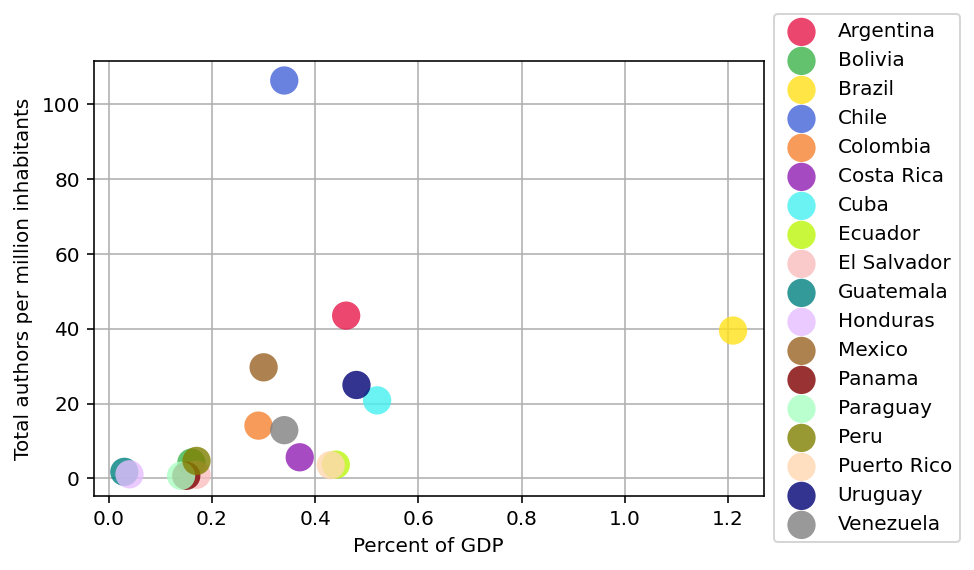

In [30]:
def gen_auths_sp():
    
    fig, ax = plt.subplots()

    data = list(zip(LA_countries, 
                    gdp.values(), 
                    authors_pc.values(), 
                    population.values()))
    
    for i in range(len(data)):
        # take care of the exceptions
        if data[i][1] is not None:
            x = data[i][1]
            y = data[i][2]
            r = data[i][3]  #radius
            #ax.scatter(x, y, label=data[i][0], s=10*r, alpha=0.8, c=colour_list[i], edgecolors='none')
            ax.scatter(x, y, label=data[i][0], s=200, alpha=0.8, c=colour_list[i], edgecolors='none')
    
    # format
    ax.set_xlabel('Percent of GDP')
    ax.set_ylabel('Total authors per million inhabitants')

    ax.grid(True)
    ax.set_axisbelow(True)
    lgnd = ax.legend()
    handles = lgnd.legendHandles

    for handle in handles:
        handle._sizes = [50]

    # Specify the legend location outside the plot
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    fig.savefig(f'../figures/authors/all_authors_sp.pdf', 
                dpi=150, bbox_inches = 'tight')

    plt.show()
    
gen_auths_sp()